In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_curve, auc,confusion_matrix
import xgboost as xgb
import seaborn as sns

In [89]:
#reading the data from the  database 
df = pd.read_csv('optimized_organ_transplant_data.csv')
print("Data inserted", df.shape) #size of the dataset 

print("dropping the null values :", df.isnull().sum().sum())
df = df.dropna()
print("after droping :", df.shape)#checking the size of the data after the dropping the null values
print("no. of values that are droped:", df.isnull().sum())

Data inserted (3903, 22)
dropping the null values : 0
after droping : (3903, 22)
no. of values that are droped: age                            0
gender                         0
bp                             0
heart_attack                   0
heart_valve                    0
heart_defect_at_birth          0
cardiomyopathy                 0
severe_cystic_fibrosis         0
copd(lung_disease)             0
repeated_urinary_infections    0
diabities                      0
kidney_stones                  0
urinary_tract_infection        0
transplant                     0
blood_type_match               0
hla_match_score                0
crossmatch_result              0
pra_score                      0
age_diff                       0
size_compatibility             0
urgency_score                  0
compatible                     0
dtype: int64


In [90]:
print("Original gender values:", df['gender'].unique())

Original gender values: ['FEMALE' 'MALE']


In [91]:
#gender mapping
gender_mapping = {'FEMALE': 0, 'MALE': 1}
df['gender'] = df['gender'].map(gender_mapping)
print("values of mapping", df['gender'].unique())

values of mapping [0 1]


In [92]:
#creating yes no values for machine to understand 
df['transplant'] = pd.get_dummies(df['transplant'], drop_first=True)
print("giving variables:", df['transplant'].head())

giving variables: 0    False
1    False
2    False
3    False
4    False
Name: transplant, dtype: bool


In [93]:
#changing the names of the coumen
df = df.rename(columns={'kidney_stones': 'kidney_stones', 'diabities': 'diabetes'})
print("Columns after renaming:\n", "\n",df.columns)

Columns after renaming:
 
 Index(['age', 'gender', 'bp', 'heart_attack', 'heart_valve',
       'heart_defect_at_birth', 'cardiomyopathy', 'severe_cystic_fibrosis',
       'copd(lung_disease)', 'repeated_urinary_infections', 'diabetes',
       'kidney_stones', 'urinary_tract_infection', 'transplant',
       'blood_type_match', 'hla_match_score', 'crossmatch_result', 'pra_score',
       'age_diff', 'size_compatibility', 'urgency_score', 'compatible'],
      dtype='object')


In [94]:
#Calculating severity indice

severity_maps = {
    'heart': {'heart_attack': 100, 'heart_valve': 10, 'heart_defect_at_birth': 50, 'cardiomyopathy': 75},
    'lung': {'copd(lung_disease)': 60, 'severe_cystic_fibrosis': 80},
    'kidney': {'kidney_stones': 20, 'repeated_urinary_infections': 30, 'urinary_tract_infection': 40}
}

for organ, severity_map in severity_maps.items():
    print(f"Calculating {organ} severity...")
    for condition, weight in severity_map.items():
        print(f"  - {condition}: {weight}")
    df[f'{organ.capitalize()}_Condition_Severity'] = sum(df[col] * weight for col, weight in severity_map.items())
    print(f"{organ.capitalize()}_Condition_Severity calculated.")

print("Calculating Chronic Condition Severity...")
df['Chronic_Condition_Severity'] = (
    df['Heart_Condition_Severity'] + df['Lung_Condition_Severity'] + df['Kidney_Condition_Severity'] + df['diabetes'] * 50
)

print("Chronic Condition Severity calculated.")

print("Calculating Age and Gender Severity...")
df['Age_Severity'] = df['age'] * df['Chronic_Condition_Severity']
df['Gender_Severity'] = df['gender'] * df['Chronic_Condition_Severity']
print("Age and Gender Severity calculated.")

print("Calculating Symptom Count...")
symptom_cols = [col for organ in severity_maps.values() for col in organ]
df['Symptom_Count'] = df[symptom_cols].sum(axis=1)
print("Symptom Count calculated")

Calculating heart severity...
  - heart_attack: 100
  - heart_valve: 10
  - heart_defect_at_birth: 50
  - cardiomyopathy: 75
Heart_Condition_Severity calculated.
Calculating lung severity...
  - copd(lung_disease): 60
  - severe_cystic_fibrosis: 80
Lung_Condition_Severity calculated.
Calculating kidney severity...
  - kidney_stones: 20
  - repeated_urinary_infections: 30
  - urinary_tract_infection: 40
Kidney_Condition_Severity calculated.
Calculating Chronic Condition Severity...
Chronic Condition Severity calculated.
Calculating Age and Gender Severity...
Age and Gender Severity calculated.
Calculating Symptom Count...
Symptom Count calculated


In [95]:

print("Selecting and scaling features...")
features = ['age', 'Heart_Condition_Severity', 'Lung_Condition_Severity', 'Kidney_Condition_Severity',
            'Chronic_Condition_Severity', 'Age_Severity', 'Gender_Severity', 'Symptom_Count',
            'blood_type_match', 'hla_match_score', 'crossmatch_result', 'pra_score', 'age_diff',
            'size_compatibility', 'urgency_score']
print("Selected features:", features)


Selecting and scaling features...
Selected features: ['age', 'Heart_Condition_Severity', 'Lung_Condition_Severity', 'Kidney_Condition_Severity', 'Chronic_Condition_Severity', 'Age_Severity', 'Gender_Severity', 'Symptom_Count', 'blood_type_match', 'hla_match_score', 'crossmatch_result', 'pra_score', 'age_diff', 'size_compatibility', 'urgency_score']


In [96]:
#MinMaxingScaler
scaler = MinMaxScaler()

print("Scaling features using MinMaxScaler...") # Converting numeric value into fix range
df[features] = scaler.fit_transform(df[features])
print("Features scaled.")

Scaling features using MinMaxScaler...
Features scaled.


In [97]:
#spliting data and checking the test shape
X = df.drop(columns=['compatible'])
y = df['compatible']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("spliting the data ", X_train.shape, "checking the test shape", X_test.shape)

spliting the data  (3122, 28) checking the test shape (781, 28)


In [98]:
print("Training XGBoost model...")
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42,
                              use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
print("XGBoost model trained.")

print("Making predictions on the test set...")
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
print("Predictions made.")

print("Evaluating XGBoost model...")
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_log_loss = log_loss(y_test, y_proba_xgb)

print("XGBoost Accuracy:", xgb_accuracy)
print("XGBoost F1 Score:", xgb_f1)
print("XGBoost Log Loss:", xgb_log_loss)
print("Evaluation complete.")

Training XGBoost model...
XGBoost model trained.
Making predictions on the test set...
Predictions made.
Evaluating XGBoost model...
XGBoost Accuracy: 1.0
XGBoost F1 Score: 1.0
XGBoost Log Loss: 0.001672593647521491
Evaluation complete.


C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:08:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23892\674383242.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.index, y=disease_counts.values, palette='viridis')


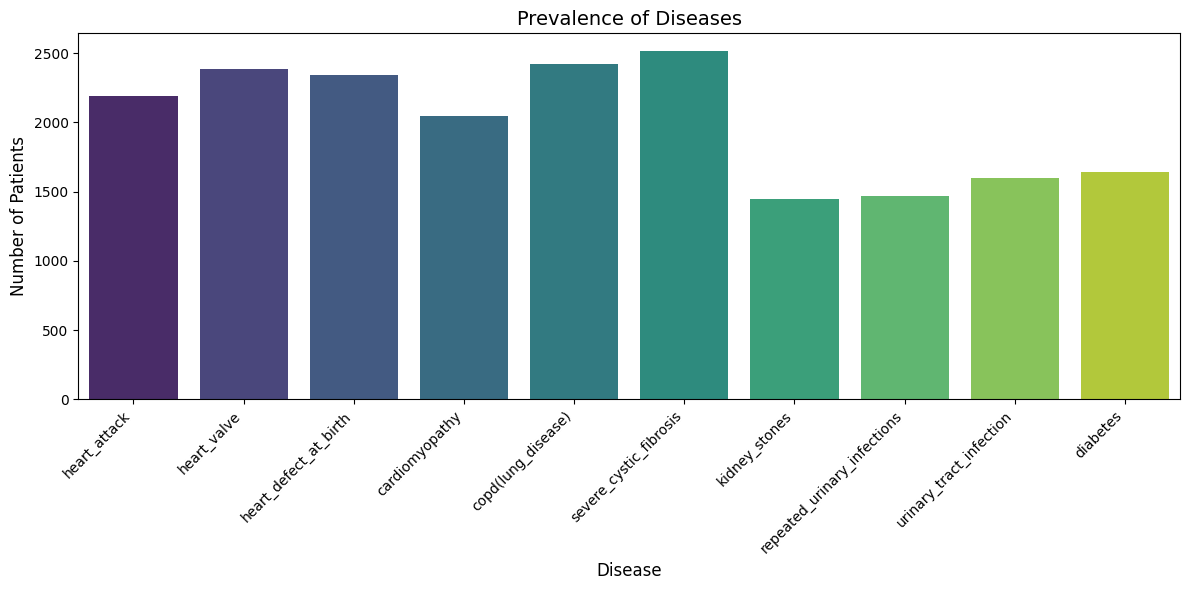

In [99]:
# Plotting graphs - Enhanced
metrics = ['Accuracy', 'F1 Score', 'Log Loss']
values = [accuracy, f1, logloss]



disease_cols = ['heart_attack', 'heart_valve', 'heart_defect_at_birth', 'cardiomyopathy',
                'copd(lung_disease)', 'severe_cystic_fibrosis', 'kidney_stones', 'repeated_urinary_infections',
                'urinary_tract_infection', 'diabetes']

disease_counts = df[disease_cols].sum()

plt.figure(figsize=(12, 6))
sns.barplot(x=disease_counts.index, y=disease_counts.values, palette='viridis')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Disease", fontsize=12)
plt.ylabel("Number of Patients", fontsize=12)
plt.title("Prevalence of Diseases", fontsize=14)
plt.tight_layout()
plt.show()

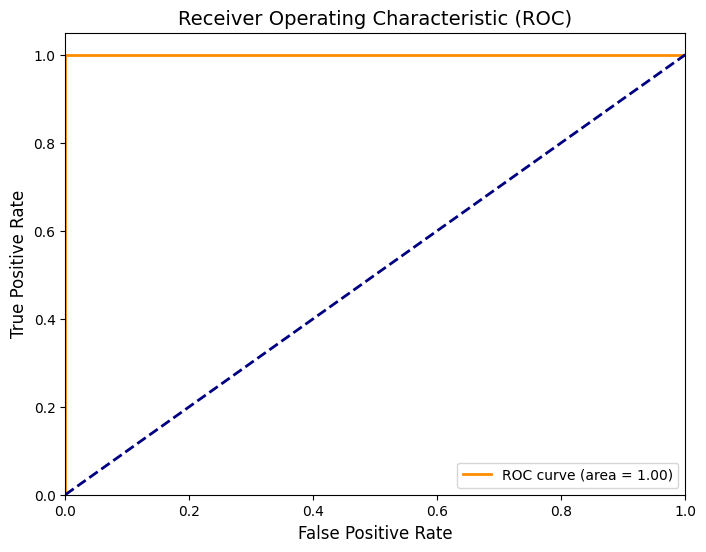

Code execution finished.


In [85]:
#making a roc curve
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
plt.legend(loc="lower right")
plt.show()

print("Code execution finished.")